In [1]:
import os , io
import requests, zipfile
from pyspark.sql import Row , SparkSession
from pyspark.context import SparkContext ,SparkConf
from pyspark.sql import SQLContext
from datetime import datetime
import sys
import re
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
spark = SparkSession.builder.appName("example").getOrCreate()
log_rdd = spark.sparkContext.textFile("access_log.txt")

In [3]:
log_pattern = r'^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)\s?(\S+)?\s?(\S+)?" (\d{3}|-) (\d+|-)\s?"?([^"]*)"?\s?"?([^"]*)?"?$'
def parse_log_line(log_line):
    match = re.match(log_pattern, log_line)
    if match:
        return {
            "ip": match.group(1),
            "client": match.group(2),
            "user": match.group(3),
            "datetime": (match.group(4)[:-6]),
            "method": match.group(5),
            "endpoint": match.group(6),
            "protocol": match.group(7),
            "response_code": match.group(8),
            "content_size": match.group(9),
            "referrer": match.group(10),
            "user_agent": match.group(11)
        }
    else:
        return None
parsed_logs = log_rdd.map(parse_log_line).filter(lambda x: x is not None)
df = spark.createDataFrame(parsed_logs)
df.show(truncate=False)
df.createOrReplaceTempView("logs_view")


+------+------------+--------------------+------------------------------------------------------------------------------------+------------+------+--------+--------+-------------+----+----------+
|client|content_size|datetime            |endpoint                                                                            |ip          |method|protocol|referrer|response_code|user|user_agent|
+------+------------+--------------------+------------------------------------------------------------------------------------+------------+------+--------+--------+-------------+----+----------+
|-     |12846       |07/Mar/2004:16:05:49|/twiki/bin/edit/Main/Double_bounce_sender?topicparent=Main.ConfigurationVariables   |64.242.88.10|GET   |HTTP/1.1|        |401          |-   |          |
|-     |4523        |07/Mar/2004:16:06:51|/twiki/bin/rdiff/TWiki/NewUserTemplate?rev1=1.3&rev2=1.2                            |64.242.88.10|GET   |HTTP/1.1|        |200          |-   |          |
|-     |6291        

In [4]:
endpoint_counts = spark.sql("SELECT endpoint, COUNT(*) as count FROM logs_view GROUP BY endpoint ORDER BY count DESC LIMIT 10")

In [5]:
endpoint_counts.show(truncate=False)

+-----------------------------------------------+-----+
|endpoint                                       |count|
+-----------------------------------------------+-----+
|/twiki/pub/TWiki/TWikiLogos/twikiRobot46x50.gif|64   |
|/                                              |47   |
|/twiki/bin/view/Main/WebHome                   |41   |
|/icons/gnu-head-tiny.jpg                       |37   |
|/icons/mailman.jpg                             |37   |
|/icons/PythonPowered.png                       |37   |
|/favicon.ico                                   |28   |
|/robots.txt                                    |27   |
|/razor.html                                    |26   |
|/twiki/bin/view/Main/SpamAssassinTaggingOnly   |18   |
+-----------------------------------------------+-----+



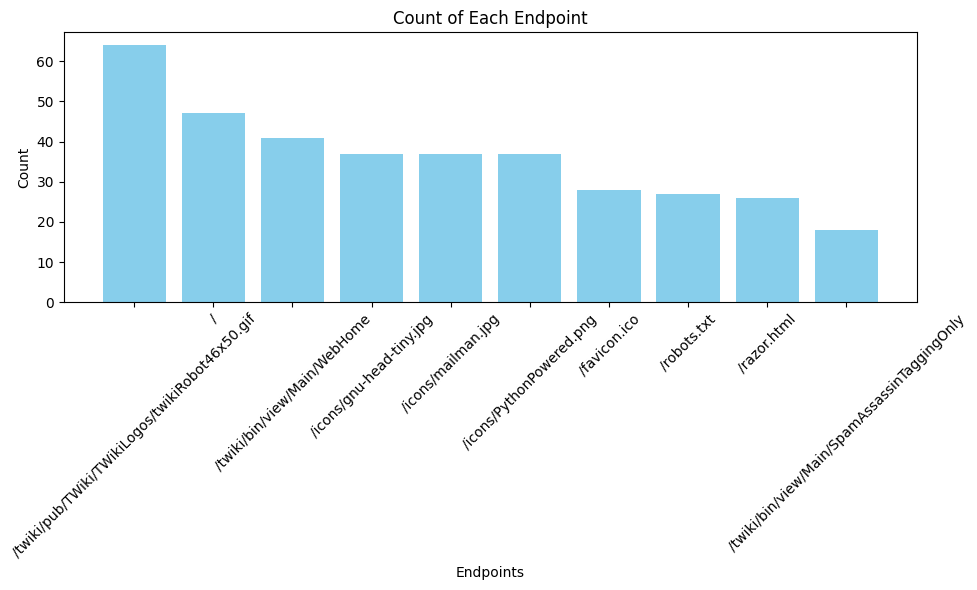

In [6]:
import matplotlib.pyplot as plt
endpoint_counts_df = endpoint_counts.toPandas()
endpoints = endpoint_counts_df['endpoint']
counts = endpoint_counts_df['count']
plt.figure(figsize=(10, 6))
plt.bar(endpoints, counts, color='skyblue')
plt.xlabel('Endpoints')
plt.ylabel('Count')
plt.title('Count of Each Endpoint')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

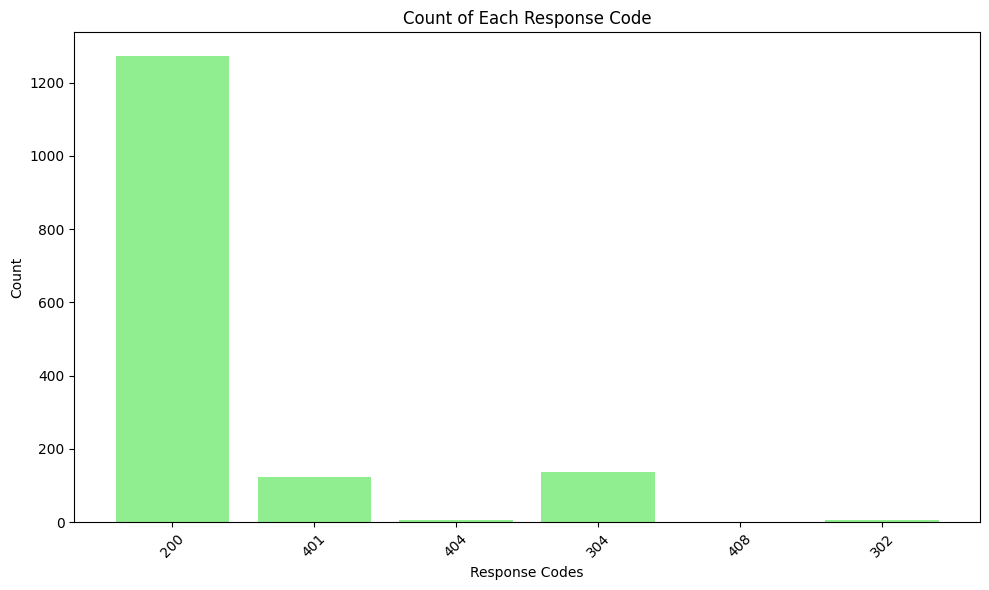

In [7]:
response_code_counts = spark.sql("SELECT response_code, COUNT(*) as count FROM logs_view GROUP BY response_code")
response_code_counts_df = response_code_counts.toPandas()
response_codes = response_code_counts_df['response_code']
counts = response_code_counts_df['count']
plt.figure(figsize=(10, 6))
plt.bar(response_codes, counts, color='lightgreen')
plt.xlabel('Response Codes')
plt.ylabel('Count')
plt.title('Count of Each Response Code')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

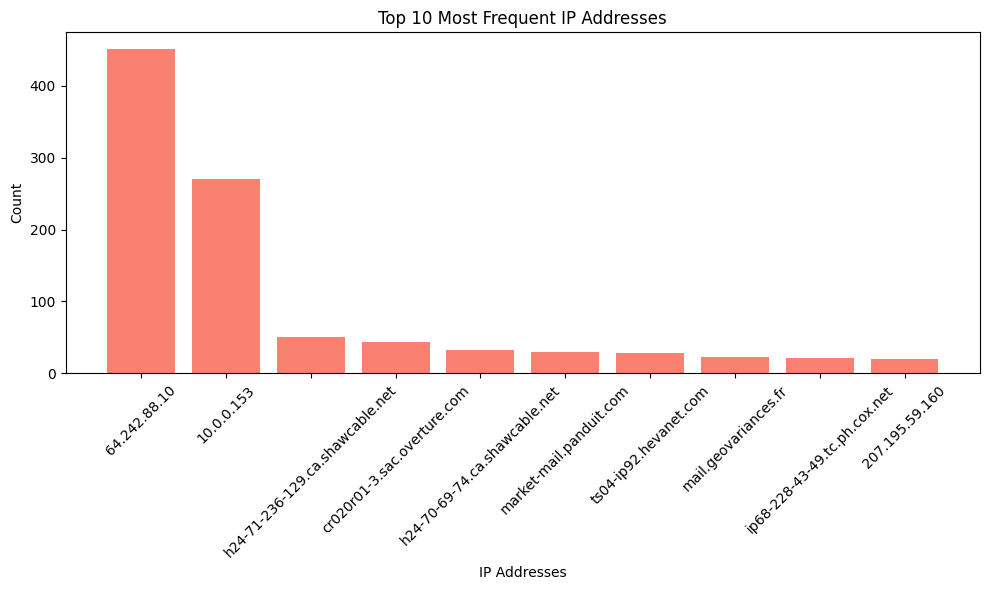

In [8]:
top_ips = spark.sql("SELECT ip, COUNT(*) as count FROM logs_view GROUP BY ip ORDER BY count DESC LIMIT 10")
top_ips_df = top_ips.toPandas()
ips = top_ips_df['ip']
counts = top_ips_df['count']
plt.figure(figsize=(10, 6))
plt.bar(ips, counts, color='salmon')
plt.xlabel('IP Addresses')
plt.ylabel('Count')
plt.title('Top 10 Most Frequent IP Addresses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


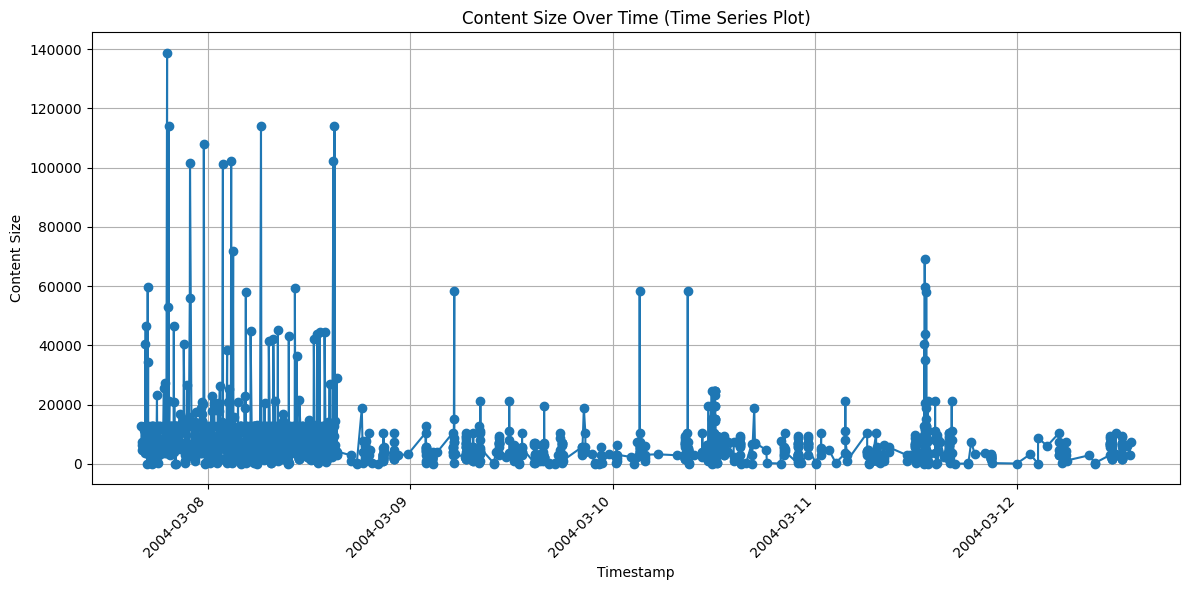

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
data = spark.sql("SELECT to_timestamp(datetime, 'dd/MMM/yyyy:HH:mm:ss') as timestamp, content_size FROM logs_view").toPandas()
data['content_size'] = pd.to_numeric(data['content_size'], errors='coerce')
data = data.dropna()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
plt.figure(figsize=(12, 6))
data['content_size'].plot(marker='o', linestyle='-')
plt.xlabel('Timestamp')
plt.ylabel('Content Size')
plt.title('Content Size Over Time (Time Series Plot)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


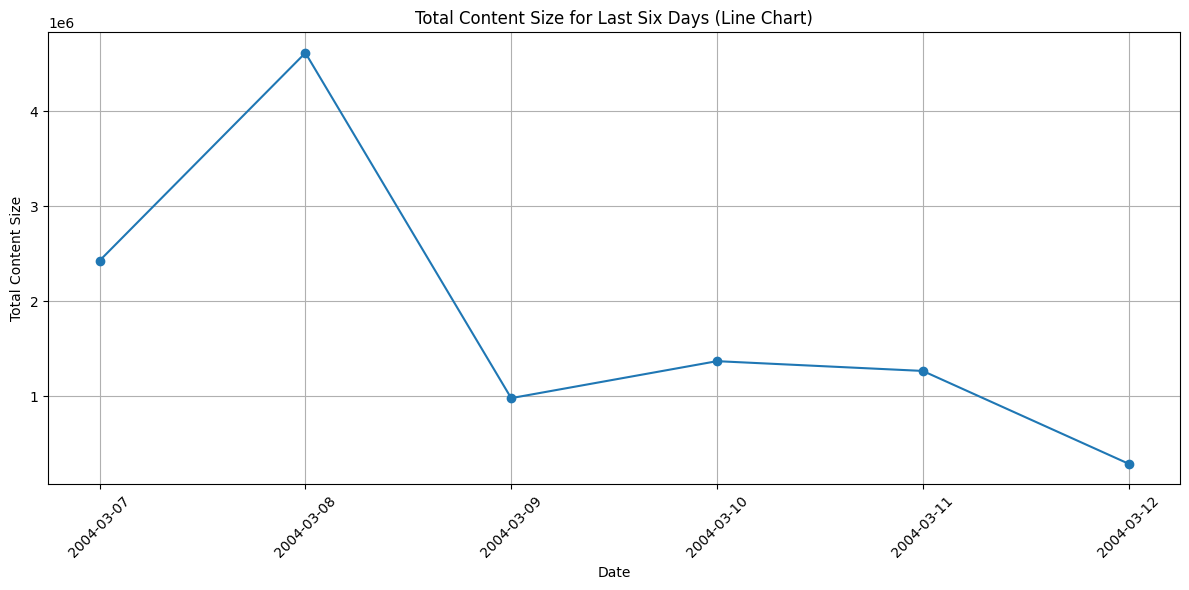

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
data = spark.sql("SELECT to_timestamp(datetime, 'dd/MMM/yyyy:HH:mm:ss') as timestamp, content_size FROM logs_view").toPandas()
data['content_size'] = pd.to_numeric(data['content_size'], errors='coerce')
data = data.dropna()
data['timestamp'] = pd.to_datetime(data['timestamp'])
daily_data = data.groupby(pd.Grouper(key='timestamp', freq='D')).sum()
last_six_days = daily_data.tail(6)
plt.figure(figsize=(12, 6))
plt.plot(last_six_days.index, last_six_days['content_size'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Content Size')
plt.title('Total Content Size for Last Six Days (Line Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


196


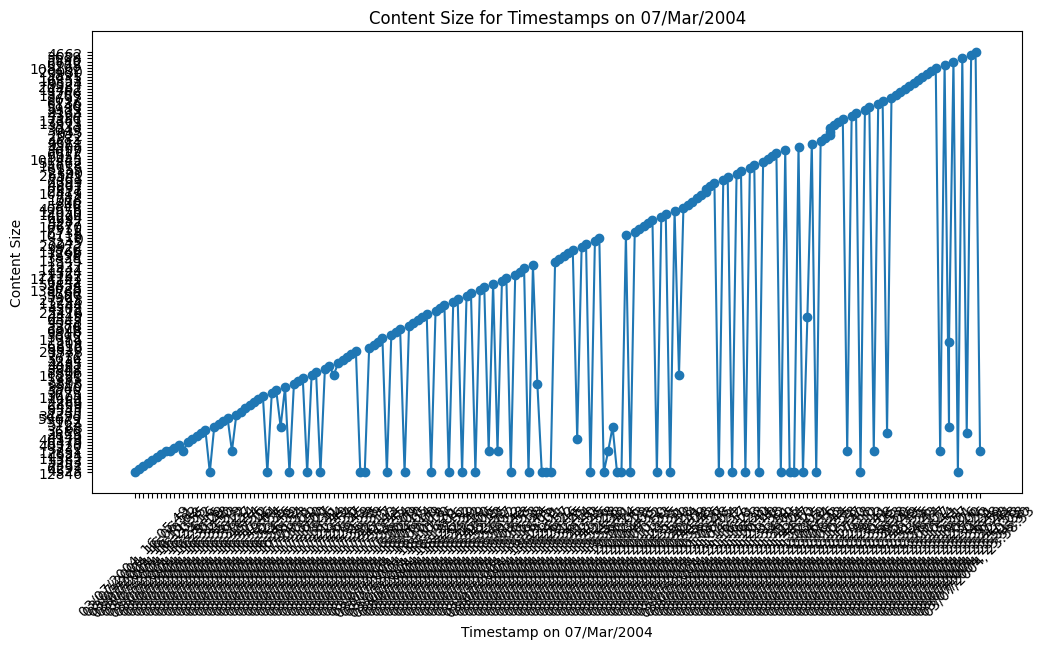

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
data = spark.sql("SELECT to_timestamp(datetime, 'dd/MMM/yyyy:HH:mm:ss') as timestamp, content_size FROM logs_view WHERE datetime LIKE '07/Mar/2004%'").toPandas()
data['timestamp'] = data['timestamp'].apply(lambda x: x.strftime('%m/%d/%Y, %H:%M:%S'))
x_label = data['timestamp'].tolist()
y_label = data['content_size'].tolist()
plt.figure(figsize=(12, 6))
plt.plot_date(x_label, y_label , linestyle='-')
plt.xlabel('Timestamp on 07/Mar/2004')
plt.ylabel('Content Size')
plt.title('Content Size for Timestamps on 07/Mar/2004')
plt.xticks(rotation=45)
plt.show()


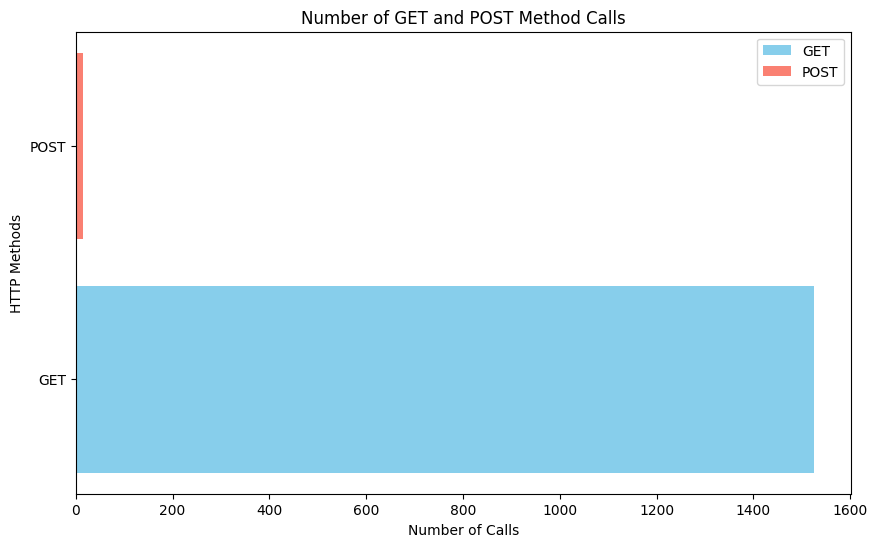

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

data = spark.sql("SELECT method, COUNT(*) as count FROM logs_view GROUP BY method").toPandas()

get_data = data[data['method'] == 'GET']
post_data = data[data['method'] == 'POST']

plt.figure(figsize=(10, 6))
plt.barh(get_data['method'], get_data['count'], color='skyblue', label='GET')
plt.barh(post_data['method'], post_data['count'], color='salmon', label='POST')
plt.xlabel('Number of Calls')
plt.ylabel('HTTP Methods')
plt.title('Number of GET and POST Method Calls')
plt.legend()
plt.show()


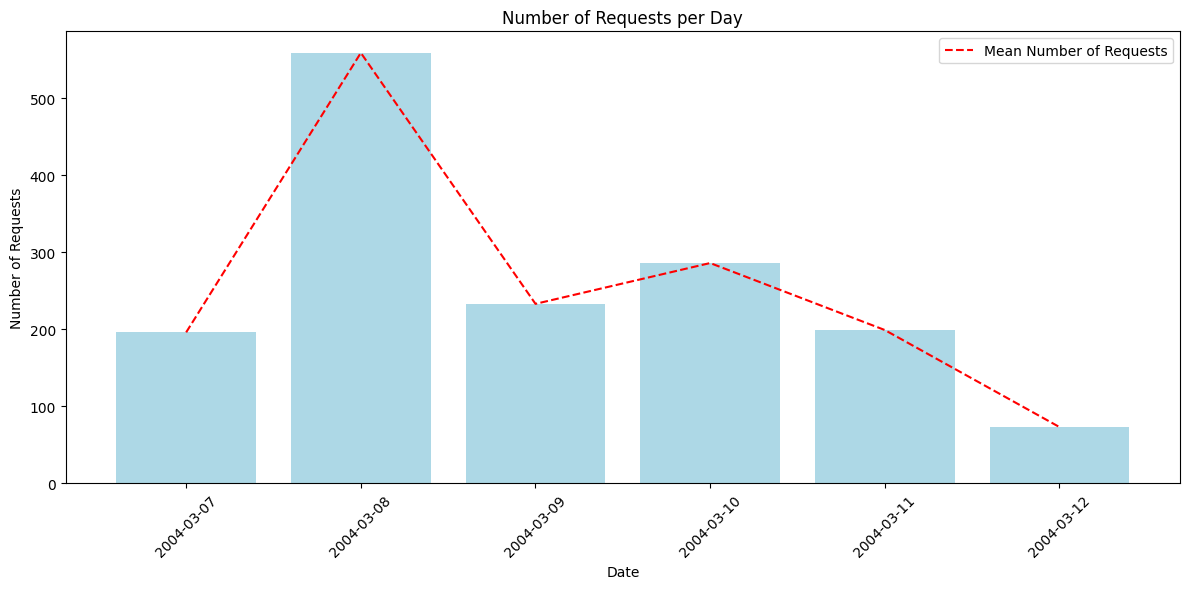

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
data = spark.sql("SELECT to_timestamp(datetime, 'dd/MMM/yyyy:HH:mm:ss') as timestamp FROM logs_view").toPandas()
data['timestamp'] = pd.to_datetime(data['timestamp'])
daily_count = data['timestamp'].dt.date.value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(daily_count.index, daily_count, color='lightblue')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.title('Number of Requests per Day')
plt.xticks(rotation=45)
plt.tight_layout()
plt.plot(daily_count.index, daily_count, linestyle='--', color='red', label='Mean Number of Requests')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()